In [1]:
import os
import sys
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import numpy.random as nprandom
import random
import math
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

random.seed(42)
np.random.seed(42)

In [2]:
IMAGE_SIZE = (256, 256)
MICROOBJECT_SIZE = 20
BACKGROUND_MICROOBJECT_SIZE_RANGE = (18, 22)
NUM_BACKGROUND_MICROOBJECTS = 50
MACROOBJECTS = ['R', 'O', 'H', 'A', 'N']
FONT_PATH = "arial.ttf"
OUTPUT_DIR = "dataset"

In [3]:
if not os.path.exists(FONT_PATH):
    if sys.platform == "win32":
        FONT_PATH = "C:\\Windows\\Fonts\\Arial.ttf"
    elif sys.platform == "darwin":
        FONT_PATH = "/Library/Fonts/Arial.ttf"
    else:
        FONT_PATH = "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf"
    if not os.path.exists(FONT_PATH):
        raise FileNotFoundError("Font file not found. Please update the FONT_PATH variable.")

if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)
os.makedirs(OUTPUT_DIR)
for obj in MACROOBJECTS:
    os.makedirs(os.path.join(OUTPUT_DIR, obj), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, 'background'), exist_ok=True)

In [4]:
class Shape(object):
    def __init__(self, center=[0,0], size=0):
        self.name = 'Shape'
        self.size = size
        self.center = center

    def overlap(self, oshape):
        left = self.center[0] - self.size / 2.
        right = self.center[0] + self.size / 2.
        up = self.center[1] - self.size / 2.
        down = self.center[1] + self.size / 2.

        oleft = oshape.center[0] - oshape.size / 2.
        oright = oshape.center[0] + oshape.size / 2.
        oup = oshape.center[1] - oshape.size / 2.
        odown = oshape.center[1] + oshape.size / 2.

        if left > oright or right < oleft or up > odown or down < oup:
            return False
        else:
            return True

class EllipseShape(Shape):
    def __init__(self, center=[0,0], size=0):
        super().__init__(center, size)
        self.name = 'Ellipse'

In [5]:
def render_letter_mask(letter, image_size=(128, 128), font_size=100):
    img = Image.new('L', image_size, 0)
    draw = ImageDraw.Draw(img)

    try:
        font = ImageFont.truetype(FONT_PATH, font_size)
    except IOError:
        font = ImageFont.load_default()

    bbox = draw.textbbox((0, 0), letter, font=font)
    text_width = bbox[2] - bbox[0]
    text_height = bbox[3] - bbox[1]

    position = ((image_size[0] - text_width) // 2 - bbox[0], (image_size[1] - text_height) // 2 - bbox[1])

    draw.text(position, letter, fill=255, font=font)

    mask = np.array(img)
    mask = mask > 128
    return mask

def place_micro_objects_within_mask(im, mask, micro_shape_func, num_micro_objects, micro_shape_params, components, fill=255):
    H, W = mask.shape
    placed = 0
    attempts = 0
    max_attempts = num_micro_objects * 10
    while placed < num_micro_objects and attempts < max_attempts:
        x = nprandom.randint(0, W)
        y = nprandom.randint(0, H)
        if mask[y, x]:
            obj = micro_shape_func(im, components, [x, y], micro_shape_params['size'], fill,
                       rescale=micro_shape_params.get('rescale', False))
            if obj is not None:
                components.append(obj)
                placed += 1
        attempts += 1
    return components

def add_distractor_micro_objects(im, distractor_shapes, num_distractors, distractor_shape_params, components):
    W, H = im.size
    placed = 0
    attempts = 0
    max_attempts = num_distractors * 10
    while placed < num_distractors and attempts < max_attempts:
        shape_func = random.choice(distractor_shapes)
        x = nprandom.randint(0, W)
        y = nprandom.randint(0, H)
        size = nprandom.randint(distractor_shape_params['size_range'][0], 
                                distractor_shape_params['size_range'][1]+1)
        obj = shape_func(im, components, [x, y], size,
                        distractor_shape_params.get('fill', 255),
                        rescale=distractor_shape_params.get('rescale', False))
        if obj is not None:
            components.append(obj)
            placed += 1
        attempts += 1
    return components

def generate_image(label, mask, micro_shape_func, num_micro_objects, distractor_shapes, num_distractors, image_size=(128, 128)):
    im = Image.new('L', image_size, 0)
    components = []

    micro_shape_params = {
        'size': MICROOBJECT_SIZE,
        'rescale': False
    }

    components = place_micro_objects_within_mask(im, mask, micro_shape_func, num_micro_objects,
                                               micro_shape_params, components, fill=255)

    distractor_shape_params = {
        'size_range': BACKGROUND_MICROOBJECT_SIZE_RANGE,
        'rescale': False,
        'fill': 255
    }

    components = add_distractor_micro_objects(im, distractor_shapes, num_distractors,
                                             distractor_shape_params, components)

    return im

def save_image(im, label, output_dir, index):
    label_dir = os.path.join(output_dir, label)
    os.makedirs(label_dir, exist_ok=True)
    filename = os.path.join(label_dir, f"{label}_{index}.png")
    im.save(filename, "PNG")


In [6]:
def generate_dataset(macroobjects, output_dir, image_size, micro_shape_func, num_micro_objects, distractor_shapes, num_distractors, samples_per_class=1000):
    for label in macroobjects:
        mask = render_letter_mask(label, image_size=image_size, font_size=300)
        for i in range(samples_per_class):
            img = generate_image(label, mask, micro_shape_func, num_micro_objects,
                                 distractor_shapes, num_distractors, image_size=image_size)
            save_image(img, label, output_dir, i)
            if i % 100 == 0:
                print(f"Generated {label} image {i}")
    print("Dataset generation completed.")


In [7]:
def micro_shape_func(im, components, center, size, fill, rescale=False):
    return drawEllipse(im, components, center, size, fill, rescale=rescale)


In [8]:
def drawEllipse(im, components, center, size, fill, rescale=False):
    obj = EllipseShape(center, size)
    for other in components:
        if obj.overlap(other):
            return None
    draw = ImageDraw.Draw(im)

    if rescale:
        w = nprandom.randint(size//2, size)
        h = nprandom.randint(size//2, size)
    else:
        w = size
        h = size

    x0 = center[0] - w // 2
    x1 = x0 + w
    y0 = center[1] - h // 2
    y1 = y0 + h

    draw.ellipse([x0, y0, x1, y1], fill=fill)
    obj.size = max(w, h)
    return obj


In [9]:
distractor_shapes = [drawEllipse]

generate_dataset(MACROOBJECTS, OUTPUT_DIR, IMAGE_SIZE, micro_shape_func, MICROOBJECT_SIZE,
                distractor_shapes, NUM_BACKGROUND_MICROOBJECTS, samples_per_class=1000)


Generated R image 0
Generated R image 100
Generated R image 200
Generated R image 300
Generated R image 400
Generated R image 500
Generated R image 600
Generated R image 700
Generated R image 800
Generated R image 900
Generated O image 0
Generated O image 100
Generated O image 200
Generated O image 300
Generated O image 400
Generated O image 500
Generated O image 600
Generated O image 700
Generated O image 800
Generated O image 900
Generated H image 0
Generated H image 100
Generated H image 200
Generated H image 300
Generated H image 400
Generated H image 500
Generated H image 600
Generated H image 700
Generated H image 800
Generated H image 900
Generated A image 0
Generated A image 100
Generated A image 200
Generated A image 300
Generated A image 400
Generated A image 500
Generated A image 600
Generated A image 700
Generated A image 800
Generated A image 900
Generated N image 0
Generated N image 100
Generated N image 200
Generated N image 300
Generated N image 400
Generated N image 50

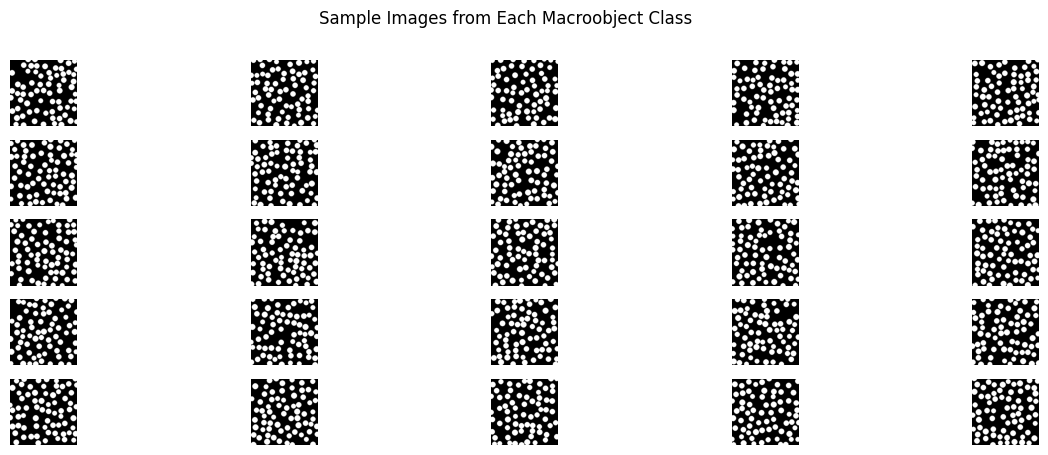

In [10]:
def visualize_samples(output_dir, macroobjects, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i, label in enumerate(macroobjects):
        for j in range(num_samples):
            img_path = os.path.join(output_dir, label, f"{label}_{j}.png")
            img = Image.open(img_path)
            plt.subplot(len(macroobjects), num_samples, i*num_samples + j + 1)
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            if j == 0:
                plt.ylabel(label, fontsize=12)
    plt.suptitle("Sample Images from Each Macroobject Class")
    plt.show()

visualize_samples(OUTPUT_DIR, MACROOBJECTS, num_samples=5)
